# Filtering of hierarchies of partitions with Higra

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

Higra's frontend is written in Python to favor ease of use and rapid developpement while it's core functions are written in c++ to ensure high performances. 

This tutorial will show you how to filter a hierarchy of partitions of an image. It is composed of 3 sections:

1. Creation of a trivial hierarchy from an image
2. Filtering of the hierarchy with various attributes
3. Visualization of the results

## Creation of a trivial hierarchy from an image

Higra integrates seamlessly with Numpy and all associated packages: we will thus rely on them for basic image manipulations.

Let's start with a bunch of imports...

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())



We will process a classical image from BSDS.

Image size: (481, 321)


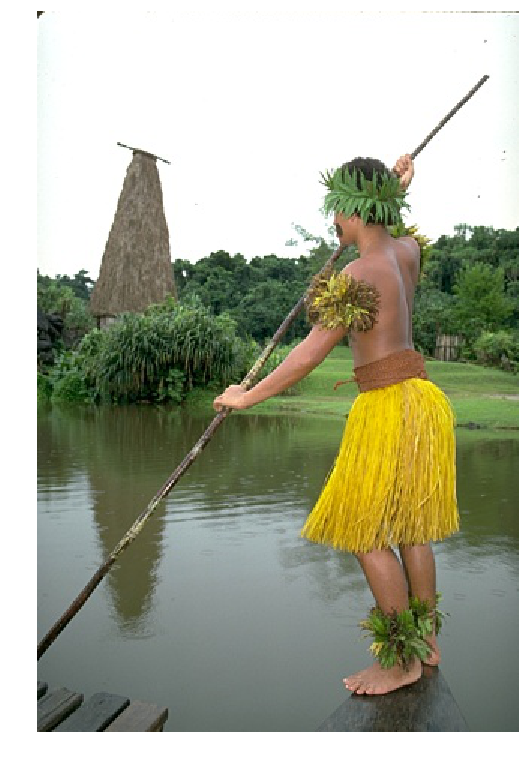

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fa0e5f66828>)

In [3]:
image = imageio.imread(locate_resource("101087.jpg"))
# switch to float to avoid numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

### Graph creation

The image will be represented as an edge weighted graph with a simple RGB gradient.

Let's start by creating a 4 adjacency pixel graph. 

In [4]:
graph = hg.get_4_adjacency_graph(size)

Now, let's compute edge weights, Higra propose some helper functions to do this efficiently for common weighting functions:

In [5]:
edge_weights = hg.weight_graph(graph, image, hg.WeightFunction.L2)

We can plot this gradient in Khalimsky space in order to see how it looks like.

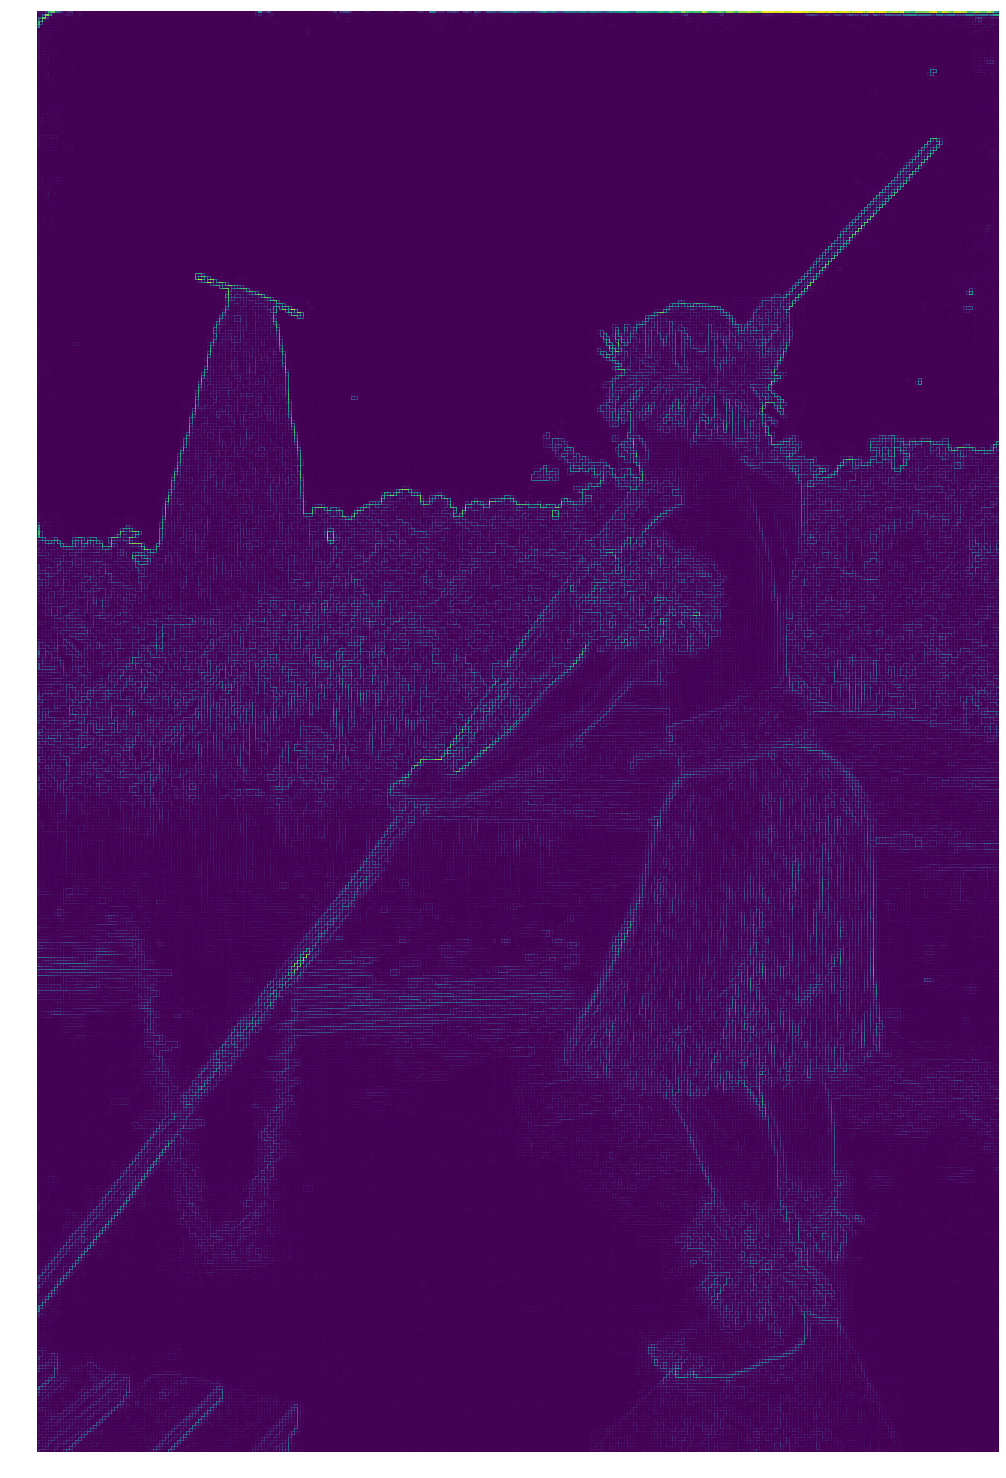

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fa0e5e92c50>)

In [6]:
gradient = hg.graph_4_adjacency_2_khalimsky(graph, edge_weights)
imshow(gradient)

### Hierarchy of partition creation

As a demo-hierarchy, we will use the canonical binary partition tree by altitude ordering from the weighted graph:

In [7]:
tree, altitudes = hg.bpt_canonical(graph, edge_weights)

In order to visualize the hierarchy we can compute its saliency map, i.e. for each edge of the base graph, compute the altitude of the smallest vertex of the tree that contains both extremities of the edge, and display the result in Khalimsky space, as we did for the gradient.

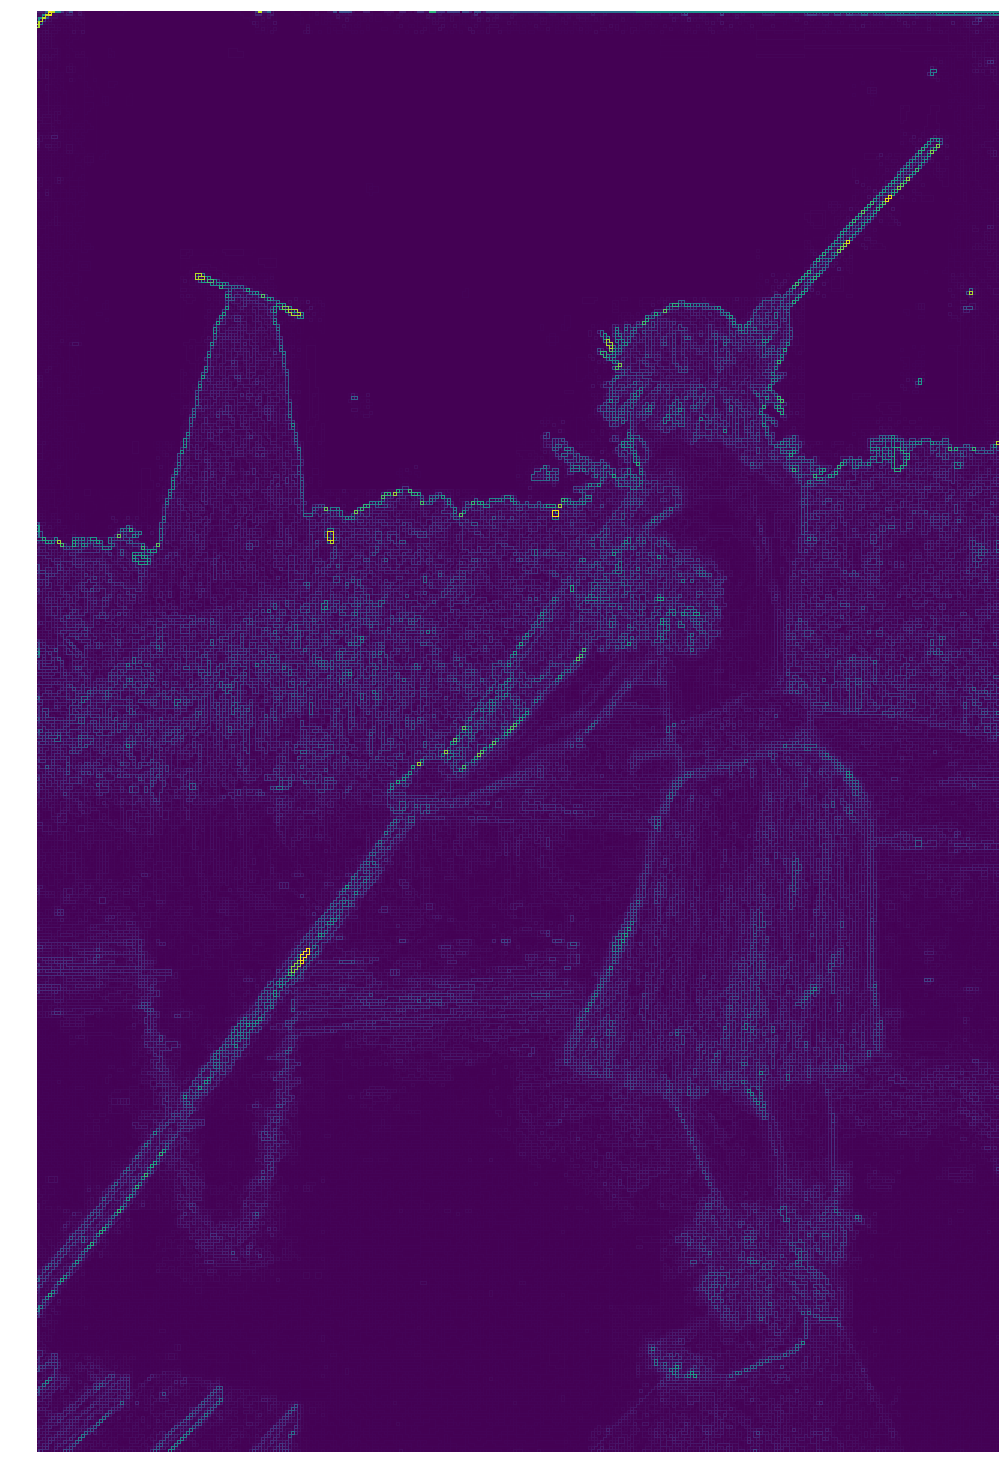

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fa0e5e4f208>)

In [8]:
saliency = hg.saliency(tree, altitudes)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, saliency))

This is not very nice and we will see in next section how to improve this hierarchy of partitions very easily


## Hierarchy filtering

The idea of hierarchy filtering is very simple. 
Each node of the binary partition tree represent the separation between its two children.
If we identify that one of the children of a node is not relevant, according to a given measure, then the separation is not relevant either: it must be set to 0. Thus, we will erase some frontiers involving non relevant nodes which will give us a new filtered gradient from which a new hierarchy can be constructed.

### Filtering criterion

The simplest way to identify non relevant nodes is to use their size: small nodes are irrelevant.

The frontier represented by a node will be deleted if one of its children has an area lower than a given threshold. To get this information we will compute for each node the minimum of the area of its children and compare it to the threshold.

Let assume that region with an area smaller than 100 pixels are not relevant

In [9]:
def is_non_relevant(tree, altitudes):
    area = hg.attribute_area(tree)
    min_area_children = hg.accumulate_parallel(tree, area, hg.Accumulators.min)
    return min_area_children <= 100

We can now filter our first hierachy according to this criterion

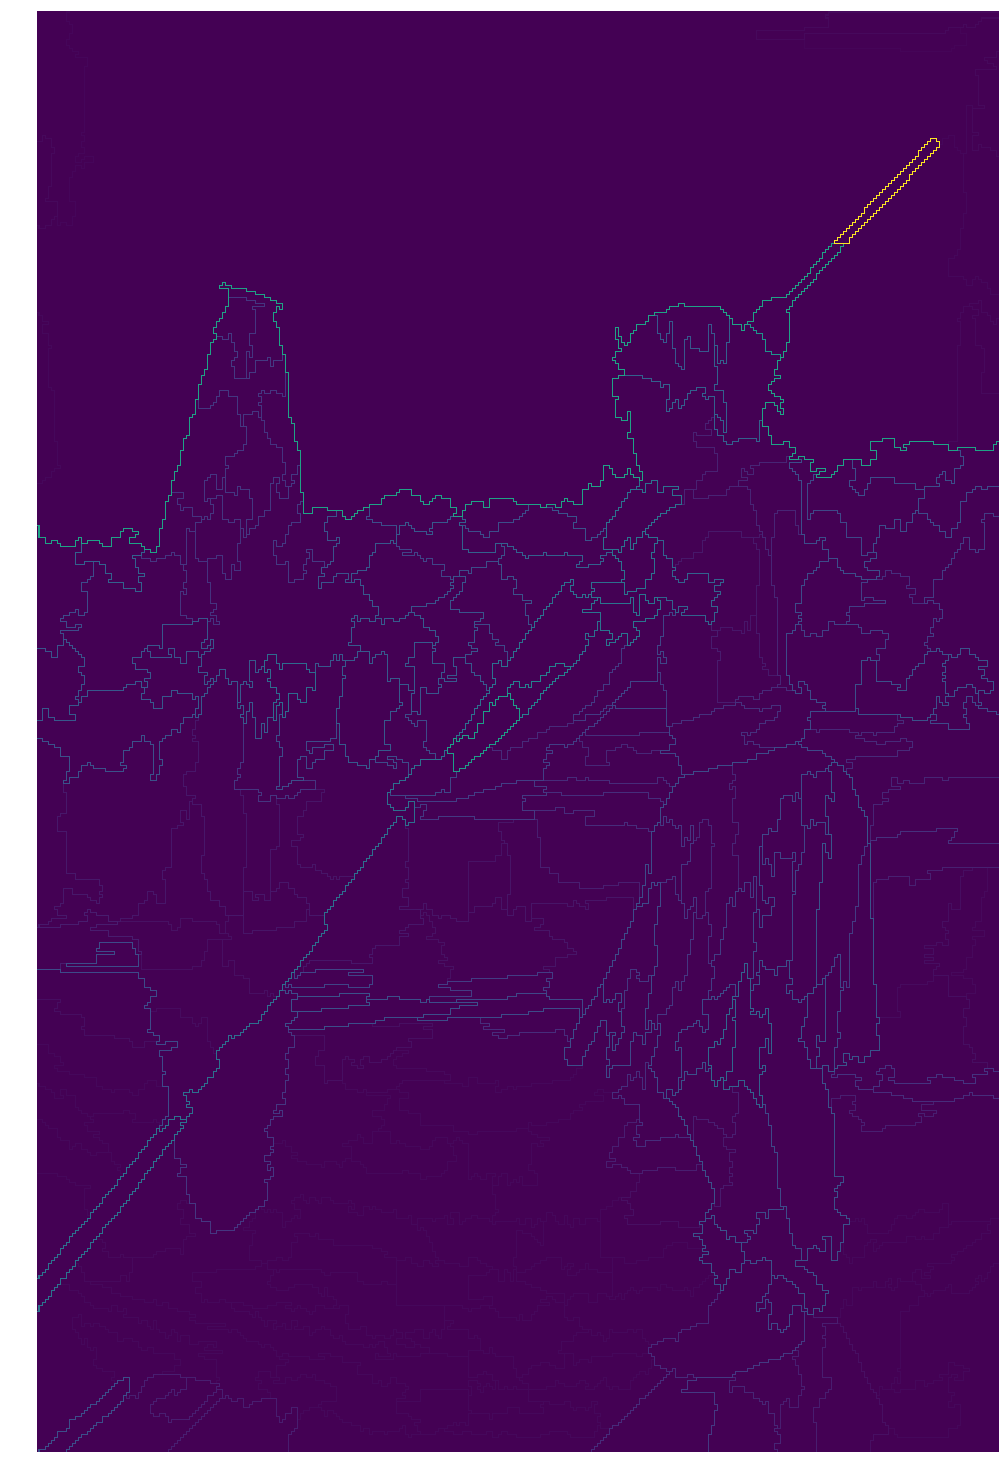

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fa0e5dba4a8>)

In [10]:
filtered_tree, filtered_altitudes = hg.filter_non_relevant_node_from_tree(tree, altitudes, is_non_relevant)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(filtered_tree, filtered_altitudes)))

# Built-in function

As removing small nodes is a common operation, one can simply use the built-in function
``hg.filter_small_nodes_from_tree``.

In [11]:
help(hg.filter_small_nodes_from_tree)

Help on function filter_small_nodes_from_tree in module higra.algo.tree:

filter_small_nodes_from_tree(tree, altitudes, size_threshold, leaf_graph)
    Filter the given tree according to node size:
    
    This function returns a binary partition tree such that:
    
        - it does not contain any region whose size is below the given threshold;
        - the regions of the new tree are either regions of the initial tree or regions obtained by merging adjacent
          regions of the initial tree.
    
    :See:
    
        :func:`~higra.filter_non_relevant_node_from_tree`
    
    :param tree: input tree (Concept :class:`~higra.CptHierarchy`)
    :param altitudes: node altitudes of the input tree
    :param size_threshold: regions whose size is smaller than this threshold will be removed (see :func:`~higra.attribute_area`)
    :param leaf_graph: graph of the tree leaves (deduced from :class:`~higra.CptHierarchy`)
    :return: a binary tree (Concept :class:`~higra.CptBinaryHierarc

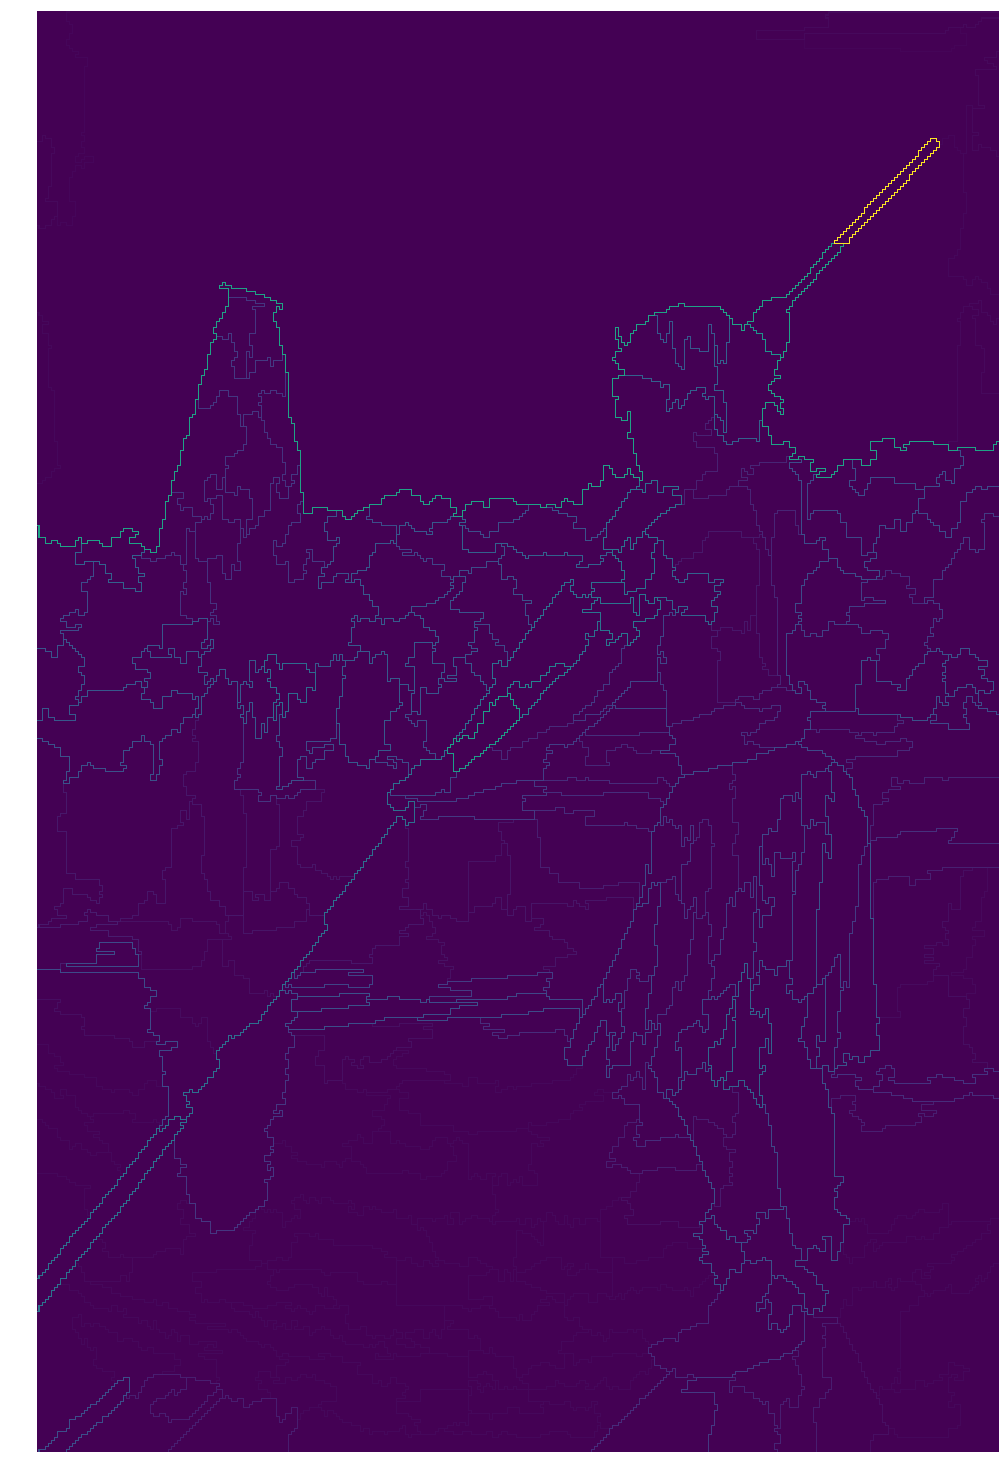

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fa0e5da0390>)

In [12]:
filtered_tree, filtered_altitudes = hg.filter_small_nodes_from_tree(tree, altitudes, 100)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(filtered_tree, filtered_altitudes)))